# Orbit response

In [1]:
import sys
import os
from os.path import join
from collections import Counter
from datetime import datetime
import h5py
from tqdm import tqdm
import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt
import proplot as pplt

sys.path.append('/Users/46h/Research/code/optimized_sav_gal/')
import sgfilter

pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'dusk_r'

In [2]:
def get_quad_id(filename):
    return filename.split('_')[5]

def get_quad_number(filename):
    return int(get_quad_id(filename)[2:])

def mean_std(x, f):
    N = np.sum(f)
    mean = np.sum(f * x) / N
    std = np.sum(f * (x - mean)**2) / N
    return mean, std

def autofilter(signal):
    n_opt = sgfilter.n_opt(signal)
    signal_filtered = sgfilter.sg_filter_gram(signal, n_opt, 2)
    return signal_filtered.values

In [3]:
folder = 'Diagnostics/Data/Measurements/2022-04-22/'
filenames = os.listdir(folder)
filenames = [filename for filename in filenames if 'orbit_response' in filename]
filenames = sorted(filenames, key=get_quad_number, reverse=True)
filenames

['220422144720-orbit_response_2d-response_HZ04_HZ06_QH13_Cam09.h5',
 '220422150322-orbit_response_2d-response_HZ04_HZ06_QV12_Cam09.h5',
 '220422151855-orbit_response_2d-response_HZ04_HZ06_QH11_Cam09.h5',
 '220422153430-orbit_response_2d-response_HZ04_HZ06_QV10_Cam09.h5',
 '220422155005-orbit_response_2d-response_HZ04_HZ06_QV09_Cam09.h5',
 '220422160543-orbit_response_2d-response_HZ04_HZ06_QH08_Cam09.h5',
 '220422162127-orbit_response_2d-response_HZ04_HZ06_QV07_Cam09.h5']

In [4]:
filename = filenames[0]
file = h5py.File(join(folder, filename), 'r')
list(file.keys())

['config', 'log', 'scandata']

In [5]:
# Errors and warnings from log
for i in range(file['log'].size):
    if not(file['/log'][i, 'level'] == 'INFO'.encode('utf')):
        timestr = datetime.fromtimestamp(file['/log'][0, 'timestamp']).strftime("%m/%d/%Y, %H:%M:%S")
        print(f"{timestr} {file['log'][i, 'message']}")

# Configuration data
for key in file['/config'].keys():
    print(f"{key}")
    print("--------------")
    for name in file['/config'][key].dtype.names:
        print(f"{name}: {file['config'][key][name]}")
    print()

environment
--------------
timestamp: [1.65065324e+09]
user: [b'46h']
host: [b'btf-diag-app1.ics.sns.gov']
cmd_line: [b'misc/orbit_response_2d.py']
work_dir: [b'/home/46h/se-template']

metadata
--------------
timestamp: [1.65065325e+09]
Test_LLRF:FCM_RFQ1:CtlAmpSet: [0.63]
RFTF_TM:Gate_BeamOn:RR: [5.]
BTF_MEBT_Mag:PS_QH01:I_Set: [157.94]
BTF_MEBT_Mag:PS_QV02:I_Set: [280.06]
BTF_MEBT_Mag:PS_QH03:I_Set: [6.75]
BTF_MEBT_Mag:PS_QV04:I_Set: [-3.75]
BTF_MEBT_Mag:PS_QH05:I_Set: [0.]
BTF_MEBT_Mag:PS_QV06:I_Set: [-0.]
BTF_MEBT_Mag:PS_QV07:I_Set: [-3.1]
BTF_MEBT_Mag:PS_QH08:I_Set: [4.1]
BTF_MEBT_Mag:PS_QV09:I_Set: [-1.85000002]
BTF_MEBT_Mag:PS_QV10:I_Set: [-1.9]
BTF_MEBT_Mag:PS_QH11:I_Set: [7.2]
BTF_MEBT_Mag:PS_QV12:I_Set: [-6.55000019]
BTF_MEBT_Mag:PS_QH13:I_Set: [6.00035858]
BTF_MEBT_Mag:PS_QH33:I_Set: [5.0999999]
BTF_MEBT_Mag:PS_QV34:I_Set: [-5.30000019]
BTF_MEBT_Mag:PS_DCH01:I_Set: [4.7]
BTF_MEBT_Mag:PS_DCV01:I_Set: [-3.]
BTF_MEBT_Mag:PS_DCH02:I_Set: [5.]
BTF_MEBT_Mag:PS_DCV02:I_Set: [-2.]


In [6]:
data = file['scandata']
print('Data:')
for i, name in enumerate(data.dtype.names):
    print(f'{name} [{data.dtype[i]}]')
print()

slits = [key for key in data.dtype.names if 'PositionSync' in key]
print(f'slits: {slits}')

Data:
timestamp [float64]
iteration [int64]
Cam09_profileY [('<f4', (512,))]
Cam09_profileX [('<f4', (612,))]
HZ04_PositionSync [float64]
HZ06_PositionSync [float64]
QH13_CurrentRb [float64]
QH13_CurrentSet [float64]

slits: ['HZ04_PositionSync', 'HZ06_PositionSync']


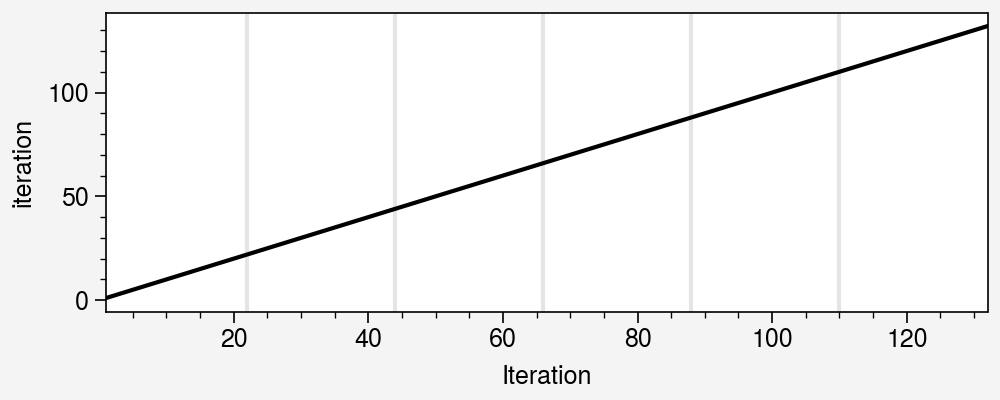

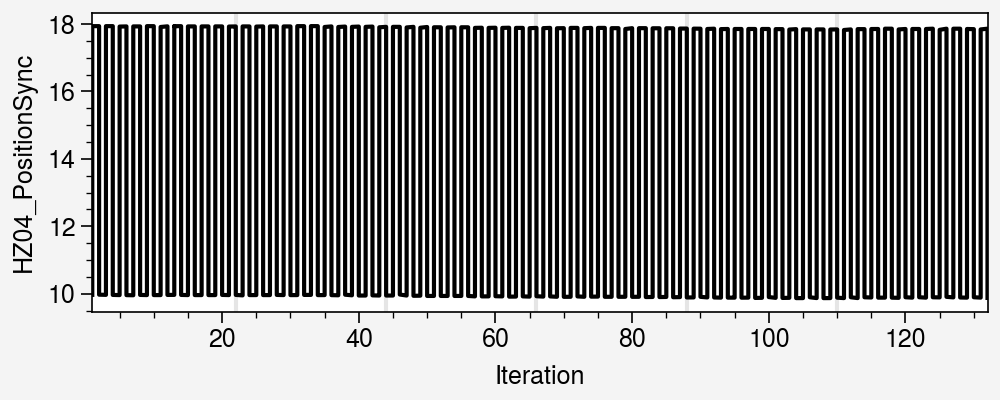

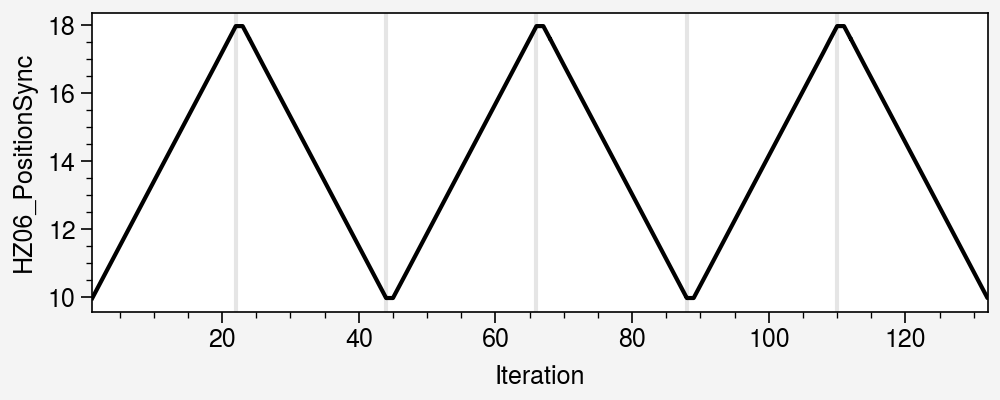

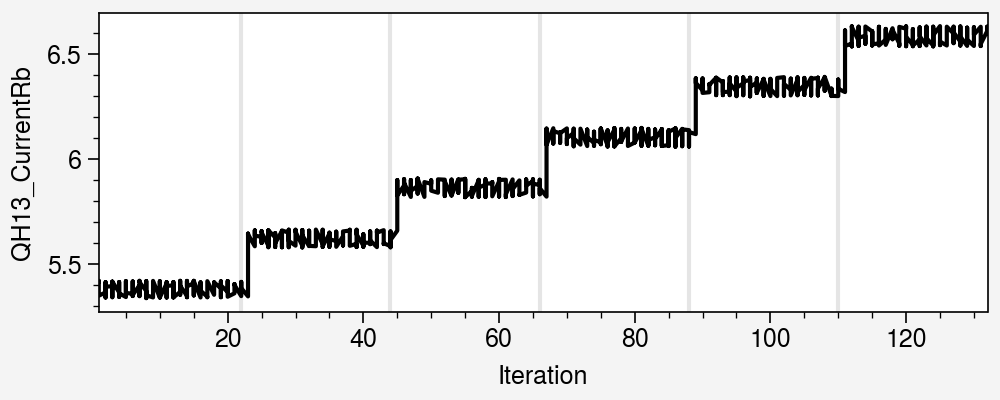

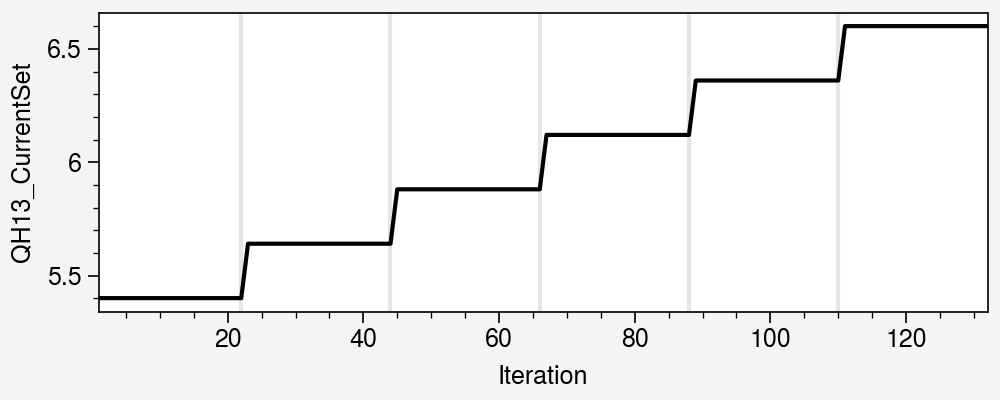

In [7]:
for name in data.dtype.names:
    if name in ['timestamp', 'Cam09_profileX', 'Cam09_profileY']:
        continue
    fig, ax = pplt.subplots(figsize=(5.0, 2.0))
    ax.plot(data['iteration'], data[name], color='black')
    for i in [22, 44, 66, 88, 110]:
        ax.axvline(i, color='black', alpha=0.1)
    ax.format(xlabel='Iteration', ylabel=name)
    plt.show()

Some of the signals are just noise.

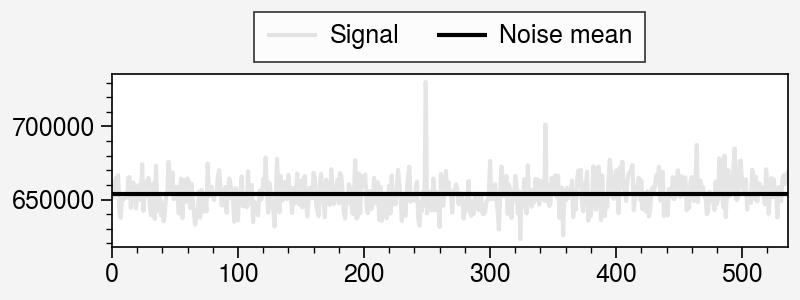

In [8]:
profile = data['Cam09_profileX'][100]
profile = profile[75:]  # No signal at beginning.
noise_mean = np.mean(profile)

fig, ax = pplt.subplots(figsize=(4.0, 1.5))
ax.plot(profile, color='black', alpha=0.1, label='Signal')
ax.axhline(noise_mean, color='black', label='Noise mean')
ax.legend(loc='top')
plt.show()

Try thresholding to get rid of noise.

In [9]:
thresh = 2e5
idx, profiles = [], []
for i, profile in enumerate(tqdm(data['Cam09_profileX'])):
    profile = profile[75:]
    profile -= noise_mean
    profile = np.clip(profile, thresh, None)
    profile -= thresh
    if np.count_nonzero(profile) > 60:
        idx.append(i)
        profiles.append(profile)
idx = np.array(idx)
profiles = np.array(profiles)

100%|██████████| 3748/3748 [00:00<00:00, 34969.56it/s]


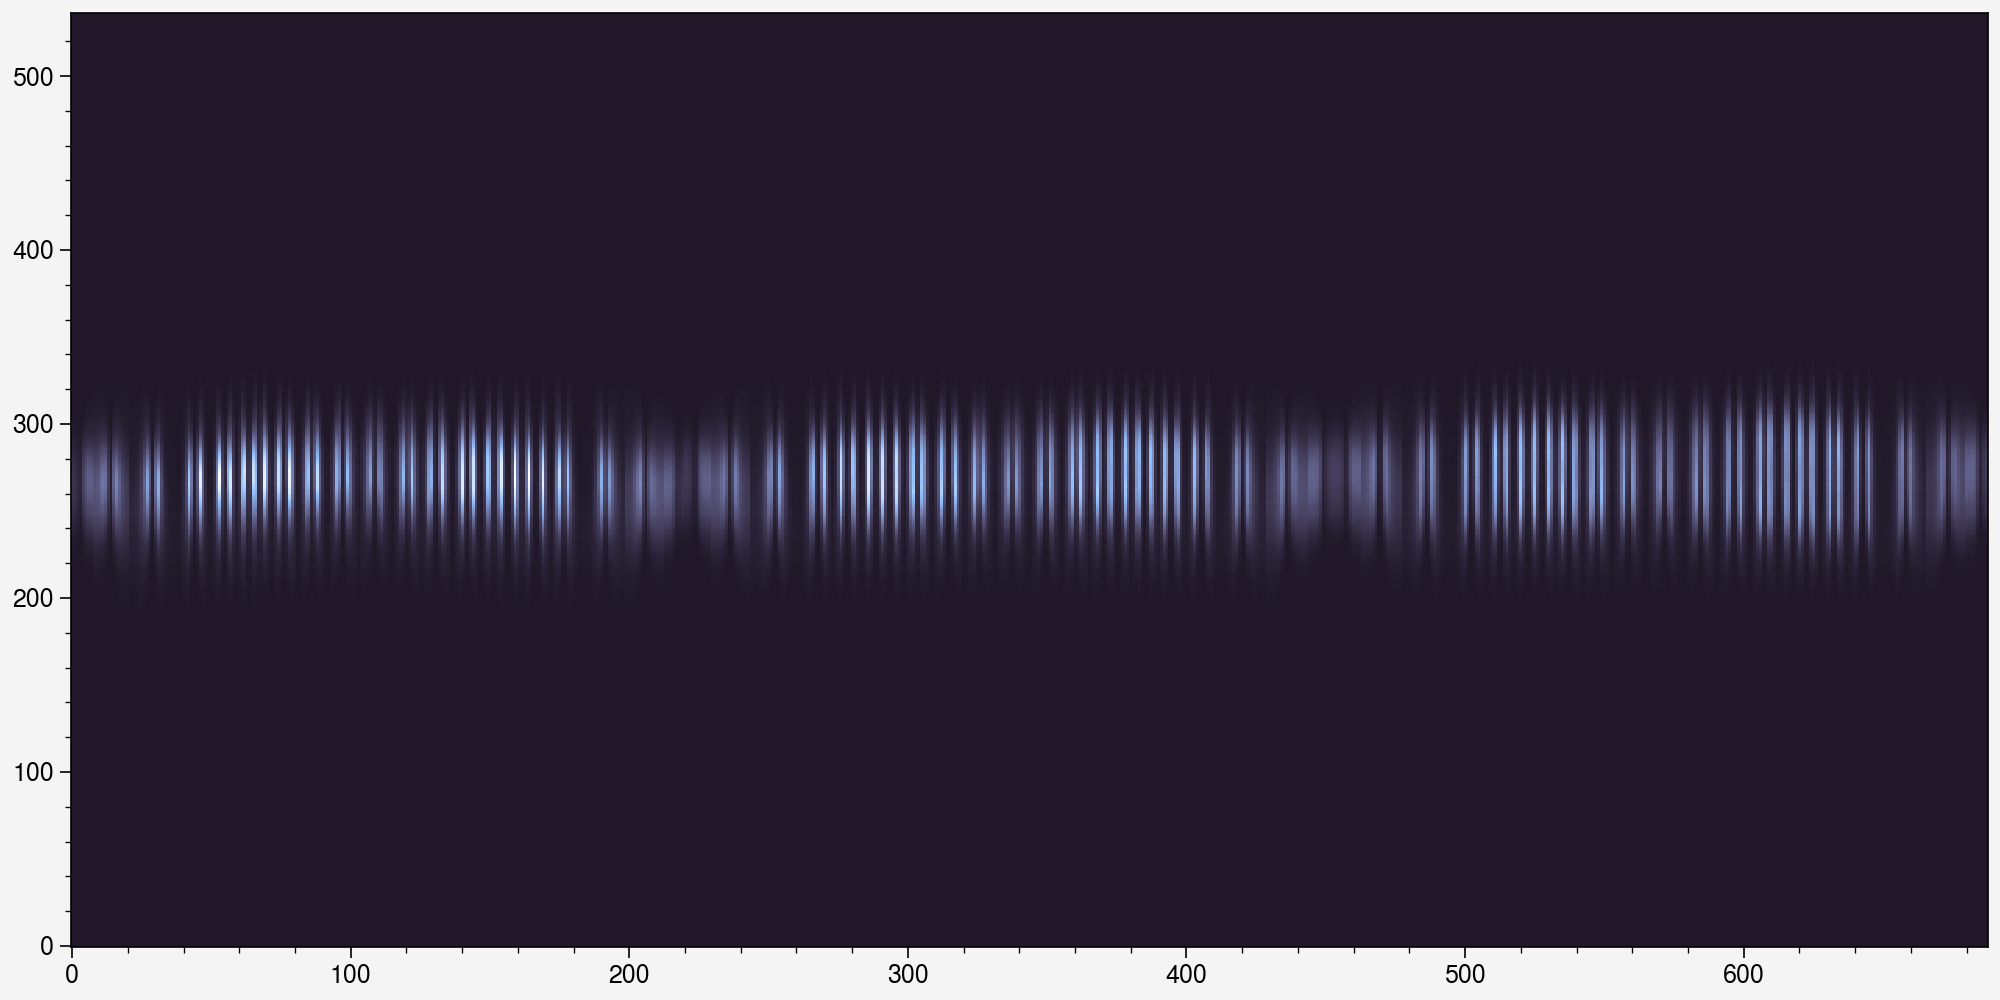

In [10]:
fig, ax = pplt.subplots(figsize=(10, 5))
ax.pcolormesh(profiles.T)
plt.show()

In [11]:
means = []
for i, profile in zip(idx, profiles):
    imax = np.argmax(profile)
    means.append(imax)

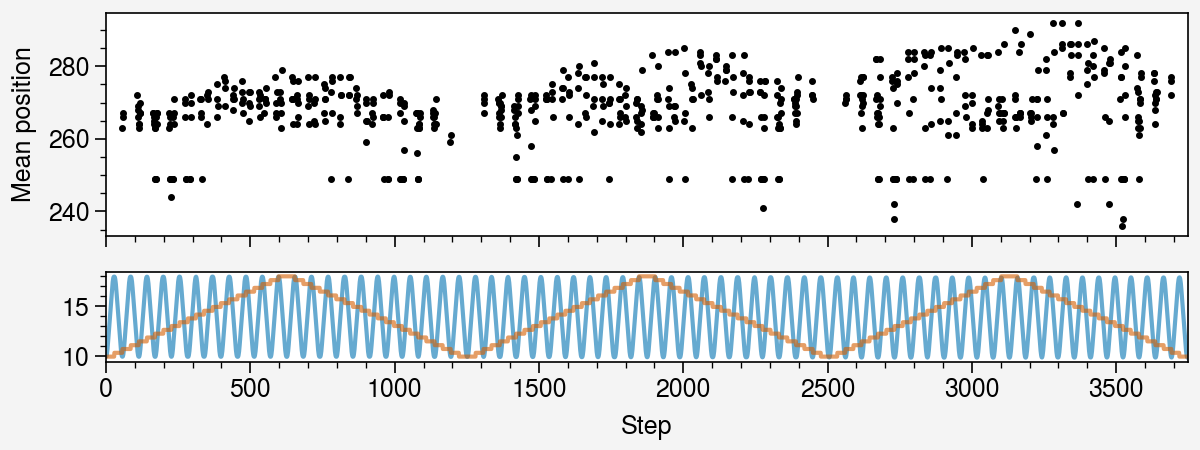

In [12]:
means_long = np.full(len(data), np.nan)
for i, mean in zip(idx, means):
    means_long[i] = mean

fig, axes = pplt.subplots(nrows=2, figsize=(6, 2.25), height_ratios=[1.0, 0.4], spany=False)
plt_kws = dict(alpha=0.6)
axes[1].plot(data['HZ04_PositionSync'], **plt_kws)
axes[1].plot(data['HZ06_PositionSync'], **plt_kws)
axes[0].plot(means_long, color='black', lw=0, marker='.', ms=3)
axes[0].format(ylabel='Mean position', xlabel='Step')
plt.show()

<a list of 1 Line2D objects>

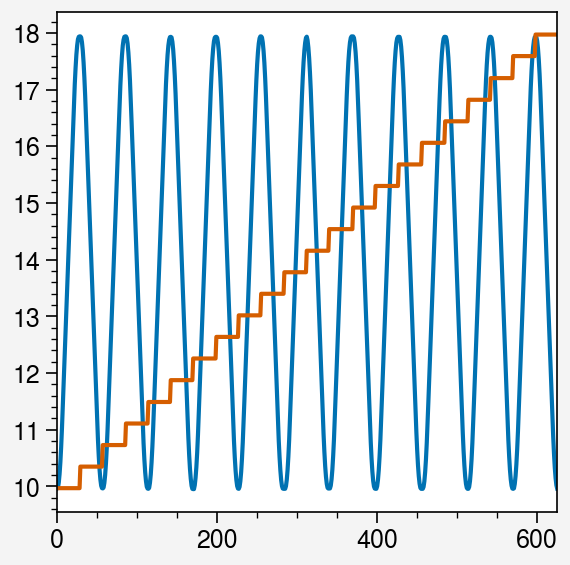

In [45]:
period_length = 22
period = 1
idx = np.logical_and(
    data['iteration'] >= (period - 1) * period_length,
    data['iteration'] < 1 + period * period_length,
)
_data = data[idx]

fig, ax = pplt.subplots()
ax.plot(_data['HZ04_PositionSync'])
ax.plot(_data['HZ06_PositionSync'])

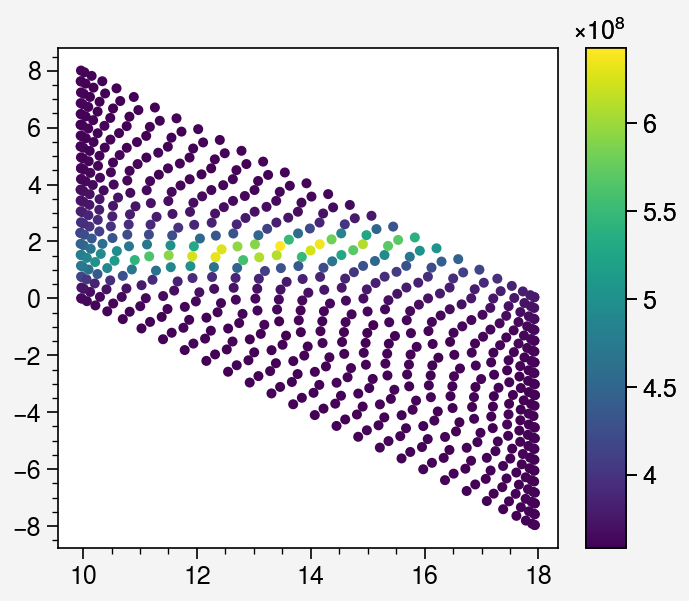

In [98]:
for period in range(1, 2):
    idx = np.logical_and(
        data['iteration'] >= (period - 1) * period_length,
        data['iteration'] < 1 + period * period_length,
    )
    _data = data[idx]
    x1 = _data['HZ04_PositionSync']
    x2 = _data['HZ06_PositionSync']
    c = np.sum(_data['Cam09_profileX'], axis=1)
    
#     X1, X2 = np.meshgrid(x1, x2)

    fig, ax = pplt.subplots()
    ax.scatter(x1, x2 - x1, c=c, marker='.', cmap='viridis', colorbar=True)
    plt.show()